# Decision Tree - Loan Approval (Synthetic dataset)



In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# Make plots render in notebook
%matplotlib inline


In [4]:
from pathlib import Path

csv_path = Path(r'C:\Users\frlmr\Documents\trabajo machine\loan_approval_synthetic.csv')
df = pd.read_csv(csv_path)
df.head()


,age,income,loan_amount,credit_score,employment_years,existing_debt,has_coapplicant,previous_defaults,marital_status,education_level,approved
0,56,75705,19701,329,2,7140,0,0,single,master,1
1,69,44418,30910,407,3,0,0,0,single,high_school,1
2,46,59907,14383,744,5,0,0,0,single,high_school,1
3,32,63178,14310,737,3,538,0,0,married,phd,1
4,60,36057,9521,756,6,2372,0,0,divorced,high_school,1


In [5]:
# Basic EDA
print('Rows, cols:', df.shape)
print('\nTarget distribution:')
print(df['approved'].value_counts(normalize=True))
print('\nData types:')
print(df.dtypes)

Rows, cols: (1200, 11)

Target distribution:
approved
1    0.721667
0    0.278333
Name: proportion, dtype: float64

Data types:
age                   int64
income                int64
loan_amount           int64
credit_score          int64
employment_years      int64
existing_debt         int64
has_coapplicant       int64
previous_defaults     int64
marital_status       object
education_level      object
approved              int64
dtype: object


In [6]:
# Preprocessing: separate features and target
X = df.drop(columns=['approved'])
y = df['approved']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
numeric_cols, categorical_cols

(['age',
  'income',
  'loan_amount',
  'credit_score',
  'employment_years',
  'existing_debt',
  'has_coapplicant',
  'previous_defaults'],
 ['marital_status', 'education_level'])

In [9]:
# ✅ Build a preprocessing + model pipeline (compatible con scikit-learn >= 1.2)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='passthrough')

clf = DecisionTreeClassifier(random_state=42, max_depth=6)

pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', clf)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Fit
pipe.fit(X_train, y_train)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.75

Classification report:
               precision    recall  f1-score   support

           0       0.57      0.45      0.50        84
           1       0.80      0.87      0.83       216

    accuracy                           0.75       300
   macro avg       0.68      0.66      0.67       300
weighted avg       0.74      0.75      0.74       300


Confusion matrix:
 [[ 38  46]
 [ 29 187]]


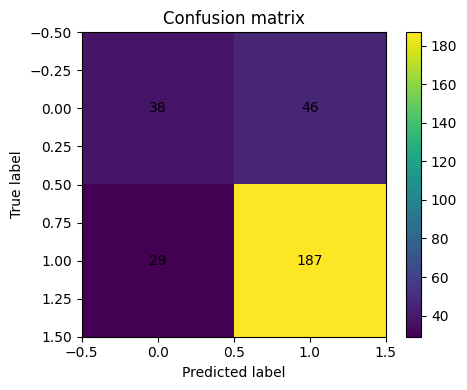

In [10]:
# Evaluation
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix:\n', cm)

# Simple confusion matrix plot
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.tight_layout()
plt.show()

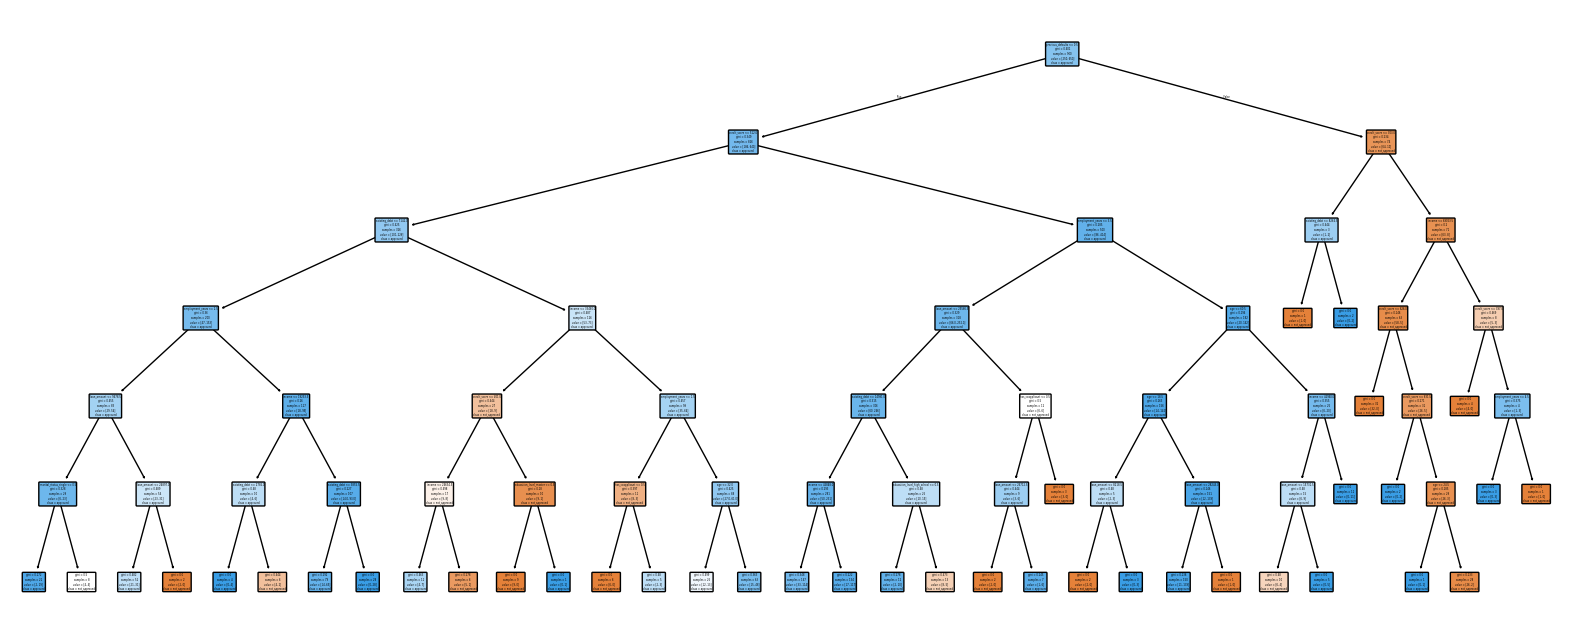

In [11]:
# Visualize the trained Decision Tree (requires matplotlib)
# Extract trained decision tree from pipeline
tree = pipe.named_steps['clf']
# Need feature names after OneHotEncoding
ohe = pipe.named_steps['pre'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = ohe_feature_names + [c for c in numeric_cols]
plt.figure(figsize=(20,8))
plot_tree(tree, feature_names=feature_names, class_names=['not_approved','approved'], filled=True, rounded=True)
plt.show()

In [18]:
from joblib import dump

# Guardar el modelo entrenado en un archivo .joblib
model_path = r'C:\Users\frlmr\Documents\trabajo machine\decision_tree_loan_model.joblib'

dump(pipe, model_path)

print(f"✅ Modelo guardado correctamente en: {model_path}")



✅ Modelo guardado correctamente en: C:\Users\frlmr\Documents\trabajo machine\decision_tree_loan_model.joblib


In [17]:
# Example: predict a new applicant
sample = {
    'age': [35],
    'income': [48000],
    'loan_amount': [8000],
    'credit_score': [660],
    'employment_years': [4],
    'existing_debt': [2000],
    'has_coapplicant': [0],
    'previous_defaults': [0],
    'marital_status': ['married'],
    'education_level': ['bachelor']
}
sample_df = pd.DataFrame(sample)
pred = pipe.predict(sample_df)
prob = pipe.predict_proba(sample_df)[:,1]
print('Prediction (1=approved):', pred[0], ' - probability approved:', round(prob[0],3))

Prediction (1=approved): 1  - probability approved: 0.927
